In [1]:
import warnings
import os
import time
import numpy as np
import pandas as pd
import random
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.hub import load_state_dict_from_url
import torch.utils.checkpoint as cp
from torch import Tensor
from typing import Any, List, Tuple

import matplotlib.pyplot as plt
from PIL import Image

import json
from tqdm import tqdm

import sys

sys.path.insert(0, "..") # to include ../helper_evaluate.py etc.
from helper_utils import set_all_seeds, set_deterministic

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

### parameter

In [2]:
random_seed = 47
learning_rate = 0.0001
batch_size = 8
epochs = 10

num_classes = 5

DEVICE = "cuda"

save_path = "densenet.pth"

### setting

In [3]:
set_all_seeds(random_seed)

set_deterministic()

### data

In [4]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.RandomResizedCrop((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

image_path = "D:/work/data/Python/flower_data/"
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"), transform=train_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"), transform=test_transform)

flower_list = train_dataset.class_to_idx
class_dict = dict((val, key) for key, val in flower_list.items())

# dump dict too json file
json_str = json.dumps(class_dict, indent=4)
with open("class_indices.json", "w") as json_file:
    json_file.write(json_str)
#     json.dump(class_dict, json_file, ensure_ascii=False)

num_workers = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 0])
print('Using {} dataloader workers every process'.format(num_workers))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_num = len(train_dataset)
test_num = len(test_dataset)

print("train images num: ", train_num)
print("test images num: ", test_num)

for images, labels in train_loader:
    print("images shape: ", images.size())
    print("labels shape: ", labels.size())
    break

Using 0 dataloader workers every process
train images num:  3306
test images num:  364
images shape:  torch.Size([8, 3, 224, 224])
labels shape:  torch.Size([8])


### model

In [5]:
model_urls = {
    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}


class _DenseLayer(nn.Module):
    def __init__(
        self,
        num_input_features: int,
        growth_rate: int,
        bn_size: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False))
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    @staticmethod
    def any_requires_grad(self, inputs: List[Tensor]) -> bool:
        for tensor in inputs:
            if tensor.requires_grad:
                return True
        return False

    def call_checkpoint_bottleneck(self, inputs: List[Tensor]) -> Tensor:
        def closure(*ins):
            return self.bn_function(ins)

        return cp.checkpoint(closure, *inputs)


    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, inputs: Tensor) -> Tensor:  # noqa: F811
        if isinstance(inputs, Tensor):
            prev_features = [inputs]
        else:
            prev_features = inputs

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """

    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 1000,
        memory_efficient: bool = False
    ) -> None:

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


def _load_state_dict(model: nn.Module, model_url: str, progress: bool) -> None:
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)


def _densenet(
    arch: str,
    growth_rate: int,
    block_config: Tuple[int, int, int, int],
    num_init_features: int,
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> DenseNet:
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model


def densenet121(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> DenseNet:
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)


def densenet161(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> DenseNet:
    r"""Densenet-161 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """
    return _densenet('densenet161', 48, (6, 12, 36, 24), 96, pretrained, progress,
                     **kwargs)


def densenet169(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> DenseNet:
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """
    return _densenet('densenet169', 32, (6, 12, 32, 32), 64, pretrained, progress,
                     **kwargs)


def densenet201(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> DenseNet:
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """
    return _densenet('densenet201', 32, (6, 12, 48, 32), 64, pretrained, progress,
                     **kwargs)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = densenet121(num_classes=num_classes)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda


### train

In [ ]:
best_acc = 0.0
# train_steps: train_num // batch_size
train_steps = len(train_loader)
for epoch in range(epochs):
    model.train()
    train_bar = tqdm(train_loader)
    running_loss = 0.0
    for step, (images, labels) in enumerate(train_bar):
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        logits = model(images)
        
        # backward
        optimizer.zero_grad()
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        
        # update
        optimizer.step()
        
        # logging
        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss)
    
    model.eval()
    correct = 0.0
    with torch.no_grad():
        test_bar = tqdm(test_loader)
        for images, labels in test_bar:
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            _, predict_labels = torch.max(logits, dim=1)
            correct += torch.eq(predict_labels, labels).sum().float()
    
    test_acc = correct / test_num
    train_loss = running_loss / train_steps
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, train_loss, test_acc))
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_path)
        print("save model pth to %s" % (save_path))
    
print("Finished training")

### evaluate

(332, 500, 3)
torch.Size([3, 224, 224])
class: tulips   prob: 0.861


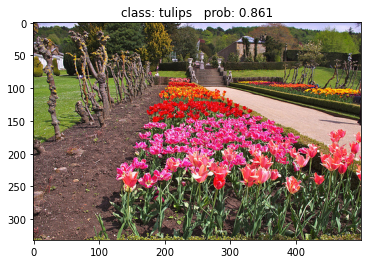

In [7]:
# load image
img_path = "D:/work/data/Python/flower_data/val/tulips/10995953955_089572caf0.jpg"
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path)

print(np.array(img).shape)
plt.imshow(img)
# [N, C, H, W]
img = test_transform(img)
print(img.shape)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

# read class_indict
json_path = './class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

json_file = open(json_path, "r")
class_indict = json.load(json_file)

# create model
model = densenet121(num_classes=num_classes)
model.to(device)

# load model weights
weights_path = "./densenet.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path))

model.eval()
with torch.no_grad():
    img = img.to(device)
    # logits shape: (1, 5)
    logits = model(img)
    logits = torch.squeeze(logits).cpu()
    predict = torch.softmax(logits, dim=0)
    # if want to use numpy(), the tensor must be on cpu
    predict_class = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_class)],
                                             predict[predict_class].numpy())
plt.title(print_res)
print(print_res)
plt.show()